Importing necessary libraries

In [175]:
import numpy as np
import random

Defining environment for RL agent

In [176]:
class MemoryAllocatorEnvironment:
    def __init__(self, memory_size):
        self.memory_size=memory_size

        #creating the memory representation
        self.memory=np.zeros(memory_size, dtype=int)
        self.allocated_blocks={}
        self.next_process_id=1
        self.fragmentation_threshold=0.8

    def reset(self):
        #clears allocations, refreshes memory
        self.memory=np.zeros(self.memory_size, dtype=int)
        self.allocated_blocks={}
        self.next_process_id=1
        initial_request_size=self._generate_allocation_request()
        return self._get_state(initial_request_size)
    
    def _get_state(self, current_request_size):
        #a simple low cost state representation of memory
        memory_status=np.array(self.memory>0, dtype=int)
        return np.concatenate([memory_status, [current_request_size/self.memory_size]])
    
    def step(self, action, request_size=None):
        #allocates memory based on action
        if request_size is None:    
            request_size=self._generate_allocation_request()
        reward=0
        done=False
        info={}

        if 0<=action<=self.memory_size - request_size:
            if np.all(self.memory[action:action+request_size]==0):
                #allocating memory
                process_id = self.next_process_id
                self.memory[action : action + request_size] = process_id
                self.allocated_blocks[process_id]=(action, request_size)
                self.next_process_id+=1
                reward= 0.1  # Small positive reward for successful allocation
            else:
                reward= -1.0  # Negative reward for attempting to allocate in occupied space
        else:
            reward= -1.0

        free_blocks=np.where(self.memory==0)[0] #checking for fragmentation

        if len(free_blocks>0):
            max_free_block_size=0
            current_free_block_size=0
            for i in range(len(free_blocks)):
                if i==len(free_blocks)-1 or free_blocks[i+1]!=free_blocks[i]+1:
                    max_free_block_size=max(max_free_block_size, current_free_block_size)
                    current_free_block_size=0

            if max_free_block_size<5 and np.sum(self.memory==0)/self.memory_size<(1-self.fragmentation_threshold):
                #high fragmentation
                done=True
                reward-=0.5
                info['reason']='high_Fragmentation'

        elif np.all(self.memory>0):
            done=True
            info['reason']='memory_full'

        next_state=self._get_state(request_size)
        return next_state, reward, done, info
    
    def _generate_allocation_request(self):
        #generates memory allocation request
        return random.randint(1,10)
    
    def deallocate(self, process_id=None):
        #deallocates specific process
        if self.allocated_blocks:
            if process_id is None:
                process_id = random.choice(list(self.allocated_blocks.keys()))

        if process_id in self.allocated_blocks:
            start, size=self.allocated_blocks[process_id]
            self.memory[start:start+size]=0
            del self.allocated_blocks[process_id]

    def get_available_actions(self, request_size=None):
        #returns a list  of possible starting adresses for allocations
        if request_size is None:
            request_size=self._generate_allocation_request
        
        available_actions=[]
        for i in range(self.memory_size-request_size+1):
            if np.all(self.memory[i:i+request_size]==0):
                available_actions.append(i)

        return available_actions
        
    def render(self):
        #prints the current state of the memory
        memory_representation=['_' if cell==0 else str(cell) for cell in self.memory]
        print("Memory: ", "".join(memory_representation))
        print("\n")
        print("Allocated: ", self.allocated_blocks)

Using the environment to check allocation before training

In [ ]:
if __name__=="__main__":
    env=MemoryAllocatorEnvironment(memory_size=50)
    state=env.reset()
    print("Initial State: ")
    env.render()

    custom_requests=[10, 5, 15, 2, 8]

    for request_size in custom_requests:
        available_actions=env.get_available_actions(request_size=request_size)
        if available_actions:
            action=random.choice(available_actions)
            next_state, reward, done, info=env.step(action, request_size=request_size)
            print(f"Request Size: {request_size}, Action: {action}, Reward: {reward}, Done: {done}, Info: {info}")
            env.render()
            state=next_state
            if done:
                print("Episode finished. ")
                break

        else:
            print("No available actions for request size of {request_size}.")
            break

    state=env.reset()
    env.render()

Initial State: 
Memory:  __________________________________________________


Allocated:  {}
Request Size: 10, Action: 32, Reward: 0.1, Done: False, Info: {}
Memory:  ________________________________1111111111________


Allocated:  {1: (32, 10)}
Request Size: 5, Action: 17, Reward: 0.1, Done: False, Info: {}
Memory:  _________________22222__________1111111111________


Allocated:  {1: (32, 10), 2: (17, 5)}
Request Size: 15, Action: 2, Reward: 0.1, Done: False, Info: {}
Memory:  __33333333333333322222__________1111111111________


Allocated:  {1: (32, 10), 2: (17, 5), 3: (2, 15)}
Request Size: 2, Action: 23, Reward: 0.1, Done: False, Info: {}
Memory:  __33333333333333322222_44_______1111111111________


Allocated:  {1: (32, 10), 2: (17, 5), 3: (2, 15), 4: (23, 2)}
Request Size: 8, Action: 42, Reward: 0.1, Done: False, Info: {}
Memory:  __33333333333333322222_44_______111111111155555555


Allocated:  {1: (32, 10), 2: (17, 5), 3: (2, 15), 4: (23, 2), 5: (42, 8)}
Memory:  _________________

Checking on random processes

In [178]:
def run_random_processes(env, num_steps=100):
    #run a simulation prior to training model
    state=env.reset()
    print("Initial State: ")
    env.render()

    for i in range(num_steps):
        print(f"\n----Step {i+1}----")
        if random.random()<0.7:
            #allocation
            request_size=env._generate_allocation_request()
            available_actions=env.get_available_actions(request_size=request_size)
            if available_actions:
                action=random.choice(available_actions)
                next_state, reward, done, info=env.step(action, request_size=request_size)
                print(f"Action: allocate at {action}, Reward: {reward}, Done: {done}, Info: {info}")
                state=next_state
            else:
                print(f"allocation failure for request size {request_size}")

        else:
            if env.deallocate():
                print("Action: deallocated a random process")

            else:
                print("No processes to deallocate")

        env.render()
        if done:
            print("Episode finished\n")
            break

if __name__=="__main__":
    env=MemoryAllocatorEnvironment(memory_size=100)
    run_random_processes(env, num_steps=100)


Initial State: 
Memory:  ____________________________________________________________________________________________________


Allocated:  {}

----Step 1----
Action: allocate at 89, Reward: 0.1, Done: False, Info: {}
Memory:  _________________________________________________________________________________________1111111____


Allocated:  {1: (89, 7)}

----Step 2----
No processes to deallocate
Memory:  ____________________________________________________________________________________________________


Allocated:  {}

----Step 3----
Action: allocate at 59, Reward: 0.1, Done: False, Info: {}
Memory:  ___________________________________________________________2222222222_______________________________


Allocated:  {2: (59, 10)}

----Step 4----
Action: allocate at 15, Reward: 0.1, Done: False, Info: {}
Memory:  _______________333333______________________________________2222222222_______________________________


Allocated:  {2: (59, 10), 3: (15, 6)}

----Step 5----
No processes to deall

Implementing a DQN agent to train a reinforcement learning model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

import matplotlib.pyplot as plt

In [197]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1=nn.Linear(state_size, hidden_size)
        self.fc2=nn.Linear(hidden_size, hidden_size)
        self.fc3=nn.Linear(hidden_size, action_size)

        self.reward_history=[]

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, buffer_size=10000, batch_size=64, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, device="cpu"):
        self.state_size=state_size
        self.action_size=action_size
        self.learning_rate=learning_rate
        self.gamma=gamma
        self.memory=deque(maxlen=buffer_size)
        self.batch_size=batch_size
        self.epsilon_start=epsilon_start
        self.epsilon=epsilon_start
        self.epsilon_end=epsilon_end
        self.epsilon_decay=epsilon_decay
        self.device=device

        self.q_network=QNetwork(state_size, action_size).to(self.device)
        self.target_network=QNetwork(state_size, action_size).to(self.device)
        self.optimizer=optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.update_target_network()

        self.reward_history=[]

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, available_actions, force_exploit=False):
        if force_exploit or random.random() >= self.epsilon:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            self.q_network.eval()
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            self.q_network.train()
            valid_q_values = q_values[0][available_actions]
            best_action_index = torch.argmax(valid_q_values).item()
            return available_actions[best_action_index]
        else:
            return random.choice(available_actions)
        
    def learn(self):
        if len(self.memory)<self.batch_size:
            return
        
        experiences=random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, done=zip(*experiences)

        state_tensor=torch.tensor(np.array(states), dtype=torch.float32).to(self.device)
        actions_tensor=torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        reward_tensor=torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)

        next_states_tensor=torch.tensor(np.array(next_states), dtype=torch.float32).to(self.device)
        dones_tensor=torch.tensor(done, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values=self.q_network(state_tensor).gather(1, actions_tensor)

        next_q_values=self.target_network(next_states_tensor).max(1)[0].unsqueeze(1)
        targets=reward_tensor+self.gamma*(1-dones_tensor)*next_q_values

        loss=F.mse_loss(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon=max(self.epsilon_end, self.epsilon*self.epsilon_decay)

Training Loop

In [198]:
def train(env, agent, n_episodes=1000, update_frequency=10):
    for episode in range(n_episodes):
        state=env.reset()
        total_reward=0
        done=False

        while not done:
            current_request_size=env._generate_allocation_request()
            available_actions=env.get_available_actions(request_size=current_request_size)

            if not available_actions:
                #no valid actions
                next_state, reward, done, info=env.step(0, request_size=current_request_size)

            else:
                action=agent.act(state, available_actions)
                next_state, reward, done, info=env.step(action, request_size=current_request_size)

                agent.remember(state, action, reward, next_state, done)
                agent.learn()

                state=next_state
                total_reward+=reward

            if (len(agent.memory)>agent.batch_size)and(episode%update_frequency==0):
                agent.update_target_network()
            
            if done:
                print(f"Episode {episode +1}, total reward: {total_reward}, epsilon: {agent.epsilon:.2f}, info: {info.get('reason', '')}")
                agent.reward_history.append(total_reward)
                break

    plt.plot(agent.reward_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode")
    plt.grid(True)
    plt.show()


Episode 1, total reward: 0.0, epsilon: 1.00, info: high_Fragmentation
Episode 2, total reward: 0.3999999999999999, epsilon: 1.00, info: high_Fragmentation
Episode 3, total reward: 0.5999999999999999, epsilon: 1.00, info: high_Fragmentation
Episode 4, total reward: 0.29999999999999993, epsilon: 1.00, info: high_Fragmentation
Episode 5, total reward: 0.09999999999999998, epsilon: 1.00, info: high_Fragmentation
Episode 6, total reward: 0.5999999999999999, epsilon: 1.00, info: high_Fragmentation
Episode 7, total reward: 0.09999999999999998, epsilon: 1.00, info: high_Fragmentation
Episode 8, total reward: 0.29999999999999993, epsilon: 0.99, info: high_Fragmentation
Episode 9, total reward: 0.19999999999999996, epsilon: 0.96, info: high_Fragmentation
Episode 10, total reward: 0.3999999999999999, epsilon: 0.92, info: high_Fragmentation
Episode 11, total reward: 0.3999999999999999, epsilon: 0.88, info: high_Fragmentation
Episode 12, total reward: 0.5999999999999999, epsilon: 0.83, info: high_F

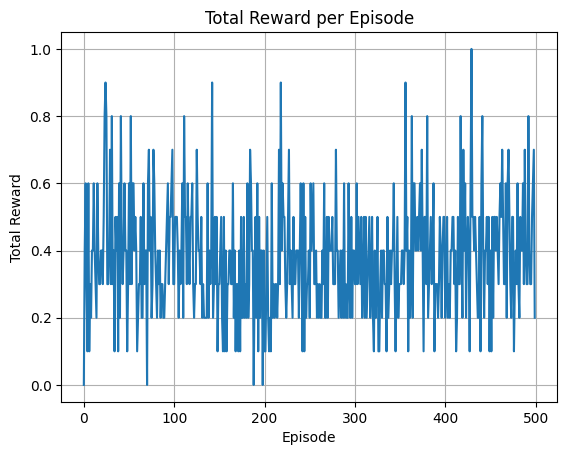

In [199]:
if __name__=="__main__":
    memory_size=50
    env=MemoryAllocatorEnvironment(memory_size)
    state_size=memory_size+1
    action_size=memory_size

    agent=DQNAgent(state_size, action_size, learning_rate=0.001, gamma=0.99, buffer_size=10000, batch_size=64, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995)

    train(env, agent, n_episodes=500)

Disabling exploration for the agent, and observing results

Episode 1, total reward: 1.1, epsilon: 1.00, info: high_Fragmentation
Episode 2, total reward: 1.3000000000000003, epsilon: 1.00, info: high_Fragmentation
Episode 3, total reward: 1.0, epsilon: 1.00, info: high_Fragmentation
Episode 4, total reward: 1.1, epsilon: 0.99, info: high_Fragmentation
Episode 5, total reward: 1.2000000000000002, epsilon: 0.91, info: high_Fragmentation
Episode 6, total reward: 1.5000000000000004, epsilon: 0.82, info: high_Fragmentation
Episode 7, total reward: 1.2000000000000002, epsilon: 0.76, info: high_Fragmentation
Episode 8, total reward: 1.0, epsilon: 0.70, info: high_Fragmentation
Episode 9, total reward: 0.7999999999999999, epsilon: 0.66, info: high_Fragmentation
Episode 10, total reward: 1.2000000000000002, epsilon: 0.60, info: high_Fragmentation
Episode 11, total reward: 1.3000000000000003, epsilon: 0.55, info: high_Fragmentation
Episode 12, total reward: 1.0, epsilon: 0.51, info: high_Fragmentation
Episode 13, total reward: 1.3000000000000003, epsilo

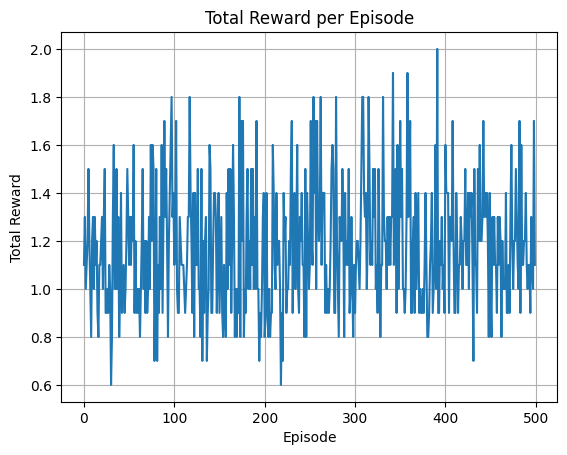

Evaluation
Evaluation Episode 1, Total Reward: 1.40, Successful Allocations: 18, Episode Length: 19, Reason: high_Fragmentation
Evaluation Episode 2, Total Reward: 1.80, Successful Allocations: 22, Episode Length: 23, Reason: high_Fragmentation
Evaluation Episode 3, Total Reward: 0.90, Successful Allocations: 13, Episode Length: 14, Reason: high_Fragmentation
Evaluation Episode 4, Total Reward: 1.20, Successful Allocations: 16, Episode Length: 17, Reason: high_Fragmentation
Evaluation Episode 5, Total Reward: 1.30, Successful Allocations: 17, Episode Length: 18, Reason: high_Fragmentation
Evaluation Episode 6, Total Reward: 0.80, Successful Allocations: 12, Episode Length: 13, Reason: high_Fragmentation
Evaluation Episode 7, Total Reward: 1.40, Successful Allocations: 18, Episode Length: 19, Reason: high_Fragmentation
Evaluation Episode 8, Total Reward: 1.10, Successful Allocations: 15, Episode Length: 16, Reason: high_Fragmentation
Evaluation Episode 9, Total Reward: 1.40, Successful 

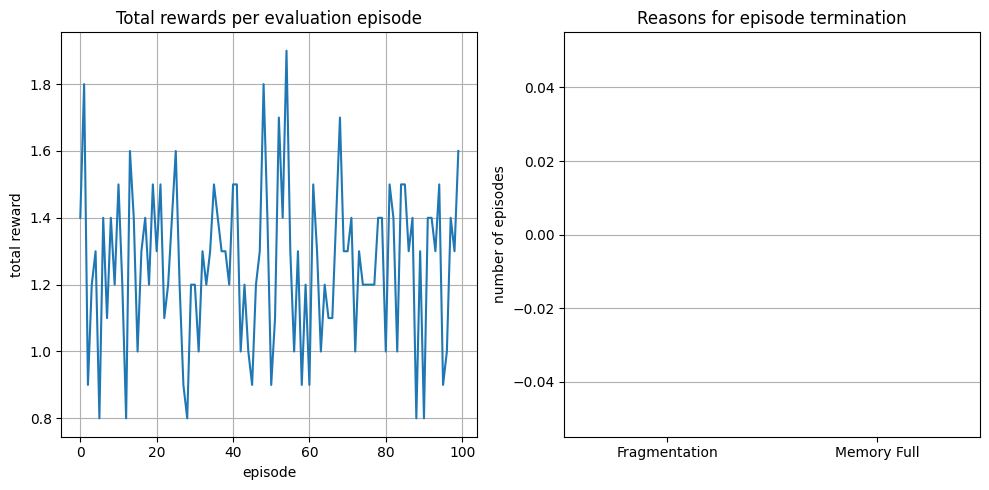

In [205]:
def evaluate(env, agent, num_episodes=100):
    print("Evaluation")
    agent.epsion=0.0
    total_rewards=[]

    succesful_allocations_list=[]
    episode_lengths=[]
    fragmentation_ends=0
    full_memory_ends=0

    for episode in range(num_episodes):
        state=env.reset()
        total_reward=0
        succesful_allocations=0
        steps=0
        done=False

        while not done:
            current_request_size=env._generate_allocation_request()
            available_actions=env.get_available_actions(request_size=current_request_size)

            if not available_actions:
                next_state, reward, done, info=env.step(0, request_size=current_request_size)
            else:
                action=agent.act(state, available_actions, force_exploit=True)
                next_state, reward, done, info=env.step(action, request_size=current_request_size)
                if reward>0:
                    succesful_allocations+=1
                state=next_state
                total_reward+=reward
                steps+=1

            if done:
                total_rewards.append(total_reward)
                succesful_allocations_list.append(succesful_allocations)
                episode_lengths.append(steps)
                if 'high_fragmentation' in info.get('reason', ''):
                    fragmentation_ends+=1
                elif 'memory_full' in info.get('reason', ''):
                    full_memory_ends+=1
                print(f"Evaluation Episode {episode + 1}, Total Reward: {total_reward:.2f}, Successful Allocations: {succesful_allocations}, Episode Length: {steps}, Reason: {info.get('reason', 'N/A')}")
                break

    print("\n--- Evaluation Summary ---")
    print(f"Average Total Reward: {np.mean(total_rewards):.2f}")
    print(f"Average Successful Allocations: {np.mean(succesful_allocations_list):.2f}")
    print(f"Average Episode Length: {np.mean(episode_lengths):.2f}")
    print(f"Episodes Ended Due to Fragmentation: {fragmentation_ends} ({fragmentation_ends / num_episodes * 100:.2f}%)")
    print(f"Episodes Ended Due to Memory Full: {full_memory_ends} ({full_memory_ends / num_episodes * 100:.2f}%)")
    agent.epsilon = agent.epsilon_start 

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(total_rewards)
    plt.title('Total rewards per evaluation episode')
    plt.xlabel('episode')
    plt.ylabel('total reward')
    plt.grid(True)

    end_reasons=['Fragmentation', 'Memory Full']
    end_counts=[fragmentation_ends, full_memory_ends]
    plt.subplot(1,2,2)
    plt.bar(end_reasons, end_counts)
    plt.title('Reasons for episode termination')
    plt.ylabel('number of episodes')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

if __name__=="__main__":
    memory_size=100
    env=MemoryAllocatorEnvironment(memory_size)
    state_size=memory_size+1
    action_size=memory_size

    agent = DQNAgent(state_size, action_size, learning_rate=0.001, gamma=0.99, buffer_size=10000, batch_size=64, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995)

    train(env, agent, n_episodes=500) # Train for some episodes
    evaluate(env, agent, num_episodes=100)

                

In [206]:
import os

save_path="D:\\collegeCode\\sem4\\csd204\\project\\memory_allocator_dqn.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(agent.q_network.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: D:\collegeCode\sem4\csd204\project\memory_allocator_dqn.pth
